In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import os

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics

import tensorflow as tf
from plot_keras_history import show_history, plot_history
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Sommaire :

4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

### <a href="#1"> Import du dataset
### <a href="#2"> Création des labels et encodage
### <a href="#3"> Création du modèle de classification
### <a href="#4"> 1) Approche préparation initiale des images
### <a href="#5"> 2) Approche ImageDatagenerator avec data augmentation
### <a href="#6"> 3) Approche nouvelle par Dataset sans data augmentation
### <a href="#7"> 4) Approche nouvelle par Dataset avec data augmentation intégrée au modèle
### <a href='#8'> Résultats

## <a name="1"> Import du dataset

In [2]:
path = "./Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

df = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")
data = df[['image','product_category_tree']]

1050


### <a name="2"> Création des labels

In [3]:
def recup_cat(liste_cat):
    """
    Renvoie la liste des catégories de liste_cat sans crochets ni apostrohes.
    Ainsi que la liste des différentes catégories.
    """
    liste = []
    l_cat = []
    for category in liste_cat:
        category = category.split(">>")[0]
        category = category.replace('"','').replace("'","").replace('[','')
        category = category[:-1]
        liste.append(category)
        if category not in(l_cat):
            l_cat.append(category)
    return liste, l_cat

In [4]:
categories, l_cat = recup_cat(data['product_category_tree'])

In [5]:
data['label_name'] = categories
data = data[['image','label_name']]
data

C:\Users\matth\AppData\Local\Temp\ipykernel_1880\4074656248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_name'] = categories


,image,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


In [6]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


## <a name="3"> Création du modèle de classification

In [7]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

## <a name="4"> 1) Approche préparation initiale des images

In [8]:
data_train, data_test = train_test_split(data, stratify=data['label'], test_size=0.2, random_state=0)
data_train.shape

(840, 3)

In [9]:
def image_prep_fct(data) :
    prepared_images = []
    for image_file in data['image'] :
        image_file = path+image_file
        img = load_img(image_file, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

D:\anaconda3\envs\tf-2-9-1\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [10]:
X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [12]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1 = time.time()

history1 = model1.fit(X_train, y_train, epochs=20, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

duration1 =time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 5.9639 - accuracy: 0.4286
Epoch 1: val_loss improved from inf to 1.26102, saving model to .\model1_best_weights.h5
10/10 [==============================] - 37s 4s/step - loss: 5.9639 - accuracy: 0.4286 - val_loss: 1.2610 - val_accuracy: 0.7143
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 2.1303 - accuracy: 0.6762
Epoch 2: val_loss improved from 1.26102 to 1.00823, saving model to .\model1_best_weights.h5
10/10 [==============================] - 35s 4s/step - loss: 2.1303 - accuracy: 0.6762 - val_loss: 1.0082 - val_accuracy: 0.7714
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.7254
Epoch 3: val_loss improved from 1.00823 to 0.90323, saving model to .\model1_best_weights.h5
10/10 [==============================] - 34s 4s/step - loss: 1.2290 - accuracy: 0.7254 - val_loss: 0.9032 - val_accuracy: 0.8000
Epoch 4/20
10/10 [==============================] - ETA:

In [14]:
loss1_train, accuracy1_train = model1.evaluate(X_train, y_train, verbose=True)
loss1_val, accuracy1_val = model1.evaluate(X_val, y_val, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 0.8913 - accuracy: 0.8286


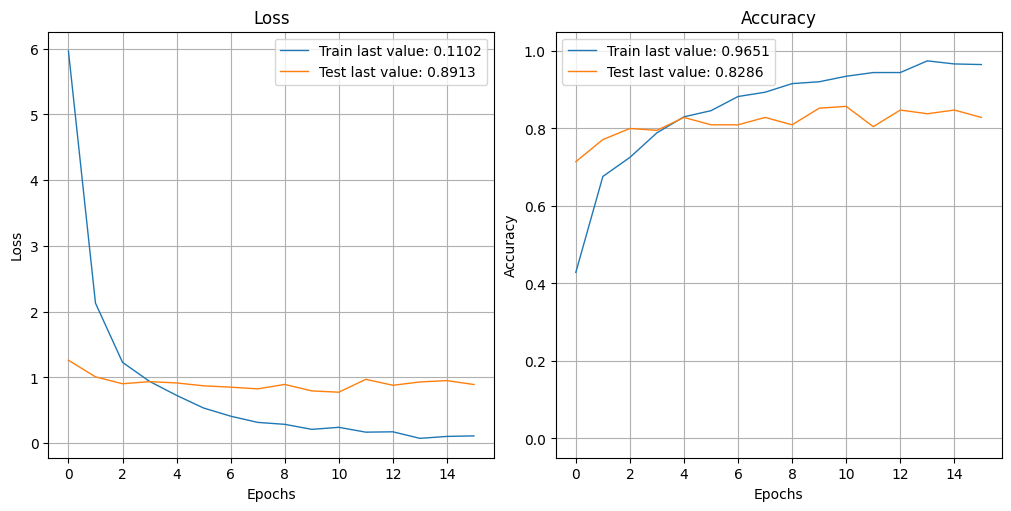

In [15]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

Les scores sont très bons mais le modèle est en overfitting.

In [16]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 9s 1s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 1 0 2 4 2 6 3 6 5 2 1 2 4 3 4 2 6 6 3 0 0 3 5 0 6 2 4 2 6 5 2
 5 6 2 0 2 6 5 2 0 5 6 4 6 5 3 3 3 5 3 5 4 0 4 0 4 6 6 2 5 0 0 2 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 0 1 3 5 4 0 5 4 6 0 2 0 3 0 5 6 3 3 6 3 1 4 3
 0 3 1 5 5 1 3 1 4 5 5 3 4 0 3 2 6 3 6 0 1 2 6 6 1 1 0 3 4 3 3 5 1 0 0 5 0
 5 3 0 6 0 0 4 0 2 4 1 2 4 5 5 2 4 1 5 2 4 1 3 2 4 6 4 2 0 3 0 5 6 2 2 0 1
 5 0 2 3 1 6 4 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]


In [17]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)
print(metrics.classification_report(y_val_num, y_val_pred))

[[22  0  1  1  4  2  0]
 [ 0 22  2  3  1  1  1]
 [ 0  1 27  0  0  2  0]
 [ 3  0  2 25  0  0  0]
 [ 7  0  0  1 22  0  0]
 [ 2  0  0  0  0 28  0]
 [ 0  1  0  1  0  0 28]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        30
           1       0.92      0.73      0.81        30
           2       0.84      0.90      0.87        30
           3       0.81      0.83      0.82        30
           4       0.81      0.73      0.77        30
           5       0.85      0.93      0.89        30
           6       0.97      0.93      0.95        30

    accuracy                           0.83       210
   macro avg       0.83      0.83      0.83       210
weighted avg       0.83      0.83      0.83       210



In [18]:
class_names = ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs',
             'Home Furnishing', 'Kitchen & Dining', 'Watches']

<Axes: >

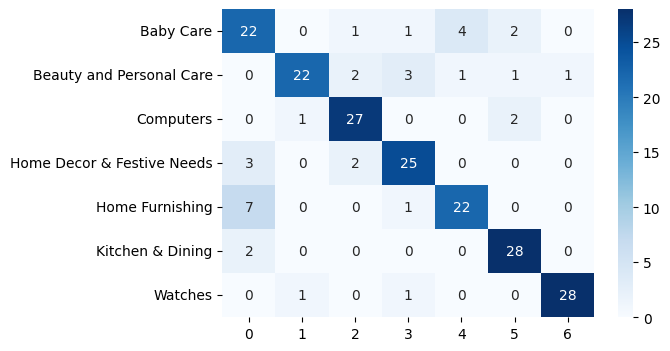

In [19]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. On a une erreur au maximum de 3 sur 25 par catégorie.

### Prédictions sur data test

In [20]:
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose = 1)
print('\nTest accuracy : ',test_acc1)

7/7 [==============================] - 9s 1s/step - loss: 1.3381 - accuracy: 0.8238

Test accuracy :  0.8238095045089722


In [21]:
predictions1 = model1.predict(X_test)

7/7 [==============================] - 9s 1s/step


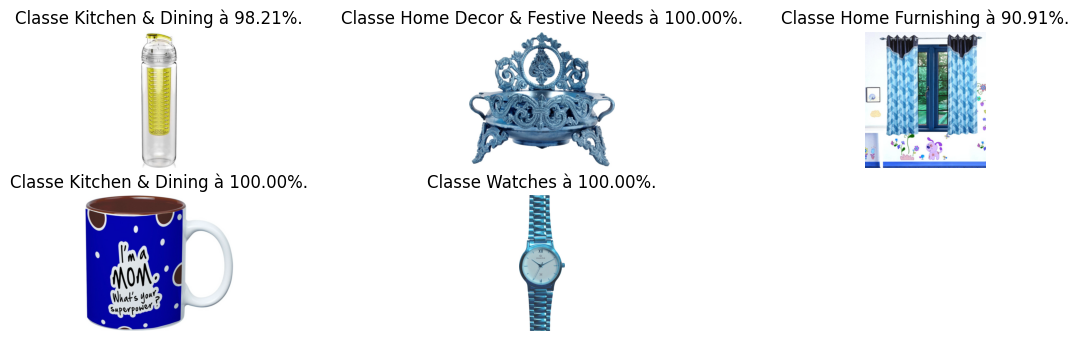

In [22]:
# Visualisation

plt.figure(figsize = (14,6))
for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    image = cv2.imread(path+data_test.iloc[10+i]['image'])
    plt.imshow(image)
    plt.title("Classe {} à {:.2f}%.".format(class_names[np.argmax(predictions1[10+i])], 100 * np.max(predictions1[10+i])))
    plt.axis("off")

Quelques exemples avec leurs prédictions. Les résultats sont corrects et la précision est très élevée.

In [23]:
labels_pred = [class_names[np.argmax(predictions1[i])] for i in range(len(predictions1))]
labels = data_test['label_name']
score1_ari = metrics.adjusted_rand_score(labels, labels_pred)
print("ARI : ", score1_ari)

ARI :  0.6424861819322982


### Batch_size à 32

In [24]:
# Création du modèle
model1b = create_model_fct()

# Création du callback
model1b_save_path1 = "./model1b_best_weights.h5"
checkpoint = ModelCheckpoint(model1b_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1b = time.time()

history1b = model1b.fit(X_train, y_train, epochs=20, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

duration1b =time.time()-temps1b
print("temps de T-SNE : ", "%15.2f" % duration1b, "secondes")

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 4.8707 - accuracy: 0.4794
Epoch 1: val_loss improved from inf to 1.16248, saving model to .\model1b_best_weights.h5
20/20 [==============================] - 35s 2s/step - loss: 4.8707 - accuracy: 0.4794 - val_loss: 1.1625 - val_accuracy: 0.7524
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.7866 - accuracy: 0.6778
Epoch 2: val_loss improved from 1.16248 to 0.96750, saving model to .\model1b_best_weights.h5
20/20 [==============================] - 35s 2s/step - loss: 1.7866 - accuracy: 0.6778 - val_loss: 0.9675 - val_accuracy: 0.7762
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.8842 - accuracy: 0.7952
Epoch 3: val_loss improved from 0.96750 to 0.91198, saving model to .\model1b_best_weights.h5
20/20 [==============================] - 35s 2s/step - loss: 0.8842 - accuracy: 0.7952 - val_loss: 0.9120 - val_accuracy: 0.7810
Epoch 4/20
20/20 [==============================] - E

In [26]:
loss1b_train, accuracy1b_train = model1.evaluate(X_train, y_train, verbose=True)
loss1b_val, accuracy1b_val = model1.evaluate(X_val, y_val, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 0.8913 - accuracy: 0.8286


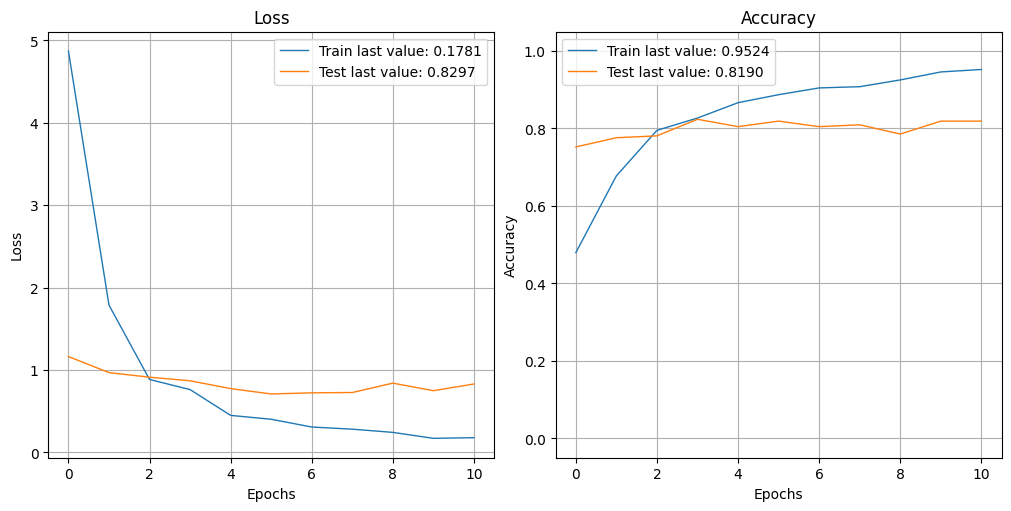

In [27]:
show_history(history1b)
plot_history(history1b, path="standard.png")
plt.close()

In [28]:
test_loss1b, test_acc1b = model1.evaluate(X_test, y_test, verbose = 1)
print('\nTest accuracy : ',test_acc1b)

7/7 [==============================] - 9s 1s/step - loss: 1.3381 - accuracy: 0.8238

Test accuracy :  0.8238095045089722


In [29]:
predictions1b = model1.predict(X_test)

7/7 [==============================] - 9s 1s/step


In [30]:
labels_pred = [class_names[np.argmax(predictions1b[i])] for i in range(len(predictions1b))]
labels = data_test['label_name']
score1b_ari = metrics.adjusted_rand_score(labels, labels_pred)
print("ARI : ", score1b_ari)

ARI :  0.6424861819322982


Les résultats sont les mêmes que le batch_size soit à 32 ou 64

## <a name="5"> 2) Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [31]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory = path,
                                x_col='image', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [32]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [33]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
temps2 = time.time()

history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)
duration2=time.time()-temps2

print("temps de T-SNE : ", "%15.2f" % duration2, "secondes")

Epoch 1/20
18/20 [==========================>...] - ETA: 2s - loss: 4.8818 - accuracy: 0.4187

D:\anaconda3\envs\tf-2-9-1\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 4.6377 - accuracy: 0.4413
Epoch 1: val_loss improved from inf to 1.29856, saving model to .\model2_best_weights.h5
20/20 [==============================] - 37s 2s/step - loss: 4.6377 - accuracy: 0.4413 - val_loss: 1.2986 - val_accuracy: 0.7714
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.7748 - accuracy: 0.6635
Epoch 2: val_loss improved from 1.29856 to 1.26663, saving model to .\model2_best_weights.h5
20/20 [==============================] - 37s 2s/step - loss: 1.7748 - accuracy: 0.6635 - val_loss: 1.2666 - val_accuracy: 0.7857
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.6825
Epoch 3: val_loss improved from 1.26663 to 1.16219, saving model to .\model2_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 1.3223 - accuracy: 0.6825 - val_loss: 1.1622 - val_accuracy: 0.7524
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss:

In [35]:
loss2_train, accuracy2_train = model2.evaluate(train_flow, verbose=True)
loss2_val, accuracy2_val = model2.evaluate(val_flow, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 1.0460 - accuracy: 0.8381


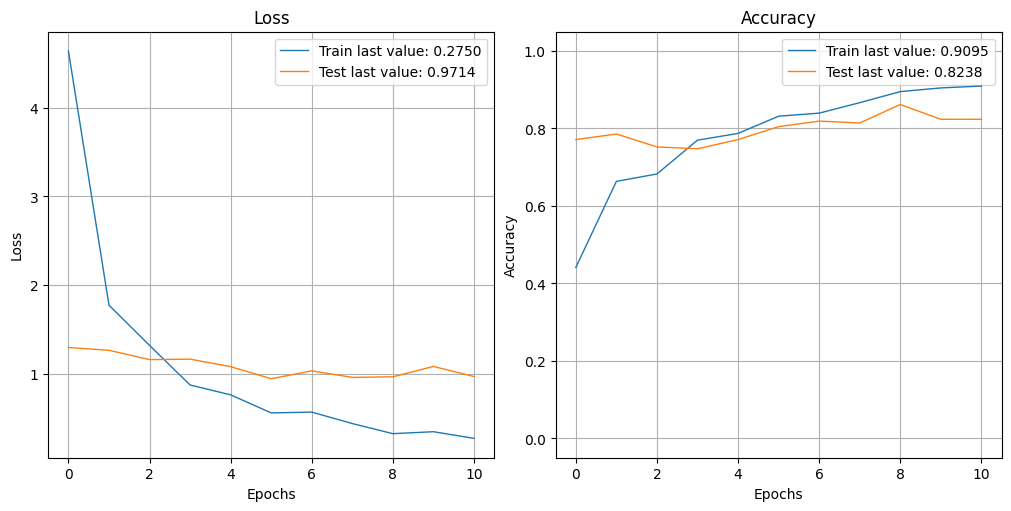

In [36]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

Les scores sont très bons. Les résultats du train_set et du validation_set sont très proches. Le modèle arrive à généraliser.

In [37]:
predicted_labels = []
true_labels = []
for i in range(len(val_flow)):
    images, labels = val_flow[i]
    predicted_labels_batch = model2.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

# Créer la matrice de confusion
confusion_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
print(confusion_mat)
print(metrics.classification_report(true_labels, predicted_labels))

1/1 [==============================] - 1s 830ms/step
[[20  0  1  2  5  2  0]
 [ 0 28  2  3  0  0  0]
 [ 0  0 27  4  0  0  2]
 [ 2  2  2 27  2  0  0]
 [ 2  0  0  1 20  0  0]
 [ 0  0  2  0  0 26  0]
 [ 0  0  0  0  0  0 28]]
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.93      0.85      0.89        33
           2       0.79      0.82      0.81        33
           3       0.73      0.77      0.75        35
           4       0.74      0.87      0.80        23
           5       0.93      0.93      0.93        28
           6       0.93      1.00      0.97        28

    accuracy                           0.84       210
   macro avg       0.84      0.84      0.84       210
weighted avg       0.84      0.84      0.84       210



<Axes: >

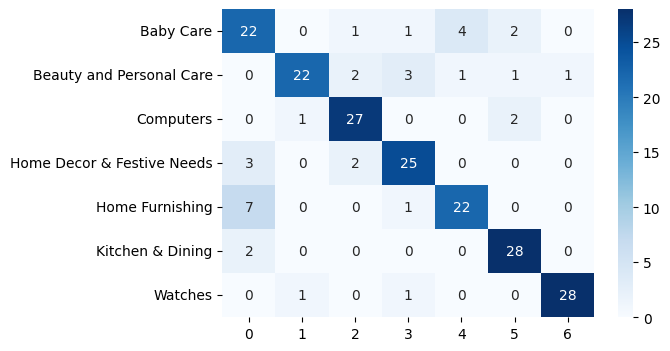

In [38]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. On a une erreur au maximum de 3 sur 25 par catégorie.

### Prédictions sur le data test

In [39]:
predictions2 = []
true_labels = []
for i in range(len(test_flow)):
    images, labels = test_flow[i]
    predictions2_batch = model2.predict(images)
    predictions2 += list(np.argmax(predictions2_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

1/1 [==============================] - 1s 756ms/step


In [40]:
score2_ari = metrics.adjusted_rand_score(true_labels, predictions2)
print("ARI : ", score2_ari)

ARI :  0.7205164395707797


In [41]:
score2_r2 = model2.evaluate(test_flow)[1]
print("r2 : ",score2_r2)

7/7 [==============================] - 9s 1s/step - loss: 1.2480 - accuracy: 0.8667
r2 :  0.8666666746139526


### Batch_size à 64

In [42]:
batch_size = 64

In [43]:
# Création du modèle
model2b = create_model_fct()

# Création du callback
model2b_save_path = "./model2b_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
temps2b = time.time()

history2b = model2b.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)
duration2b = time.time()-temps2b

print("temps de T-SNE : ", "%15.2f" % duration2b, "secondes")

Epoch 1/20
 1/20 [>.............................] - ETA: 41s - loss: 8.1841 - accuracy: 0.2188

D:\anaconda3\envs\tf-2-9-1\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 4.2905 - accuracy: 0.4508
Epoch 1: val_loss improved from inf to 1.12746, saving model to .\model2_best_weights.h5
20/20 [==============================] - 37s 2s/step - loss: 4.2905 - accuracy: 0.4508 - val_loss: 1.1275 - val_accuracy: 0.7571
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.6544 - accuracy: 0.6524
Epoch 2: val_loss improved from 1.12746 to 1.06042, saving model to .\model2_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 1.6544 - accuracy: 0.6524 - val_loss: 1.0604 - val_accuracy: 0.7667
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.2156 - accuracy: 0.7270
Epoch 3: val_loss improved from 1.06042 to 0.92863, saving model to .\model2_best_weights.h5
20/20 [==============================] - 37s 2s/step - loss: 1.2156 - accuracy: 0.7270 - val_loss: 0.9286 - val_accuracy: 0.7952
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss:

In [45]:
loss2b_train, accuracy2b_train = model2b.evaluate(train_flow, verbose=True)
loss2b_val, accuracy2b_val = model2b.evaluate(val_flow, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 0.8537 - accuracy: 0.8571


In [46]:
predictions2b = []
true_labels = []
for i in range(len(test_flow)):
    images, labels = test_flow[i]
    predictions2b_batch = model2b.predict(images)
    predictions2b += list(np.argmax(predictions2b_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

1/1 [==============================] - 1s 816ms/step


In [47]:
score2b_ari = metrics.adjusted_rand_score(true_labels, predictions2b)
print("ARI : ", score2b_ari)

ARI :  0.6489532894938838


In [48]:
score2b_r2 = model2b.evaluate(test_flow)[1]
print("r2 : ",score2b_r2)

7/7 [==============================] - 9s 1s/step - loss: 1.2475 - accuracy: 0.8286
r2 :  0.8285714387893677


Les scores sont moins bons avec un batch_size à 64 qu'à 32.

## <a name="6"> 3) Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

### Création des répertoires de classes

In [49]:
# créer les dossiers du data_train

os.mkdir('./photos_train')

import shutil

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_train/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_train.loc[data_train["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [50]:
# créer les dossiers du data_test

os.mkdir('./photos_test')

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_test/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_test.loc[data_test["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [49]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None, data=data) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [50]:
chemin_train = './photos_train/'
chemin_test = './photos_test/'

dataset_train = dataset_fct(chemin_train, validation_split=0.25, data_type='training', data = data_train)
dataset_val = dataset_fct(chemin_train, validation_split=0.25, data_type='validation', data = data_train)
dataset_test = dataset_fct(chemin_test, validation_split=0, data_type=None, data = data_test)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [51]:
class_names = dataset_train.class_names
class_names

['class_Baby Care',
 'class_Beauty and Personal Care',
 'class_Computers',
 'class_Home Decor & Festive Needs',
 'class_Home Furnishing',
 'class_Kitchen & Dining',
 'class_Watches']

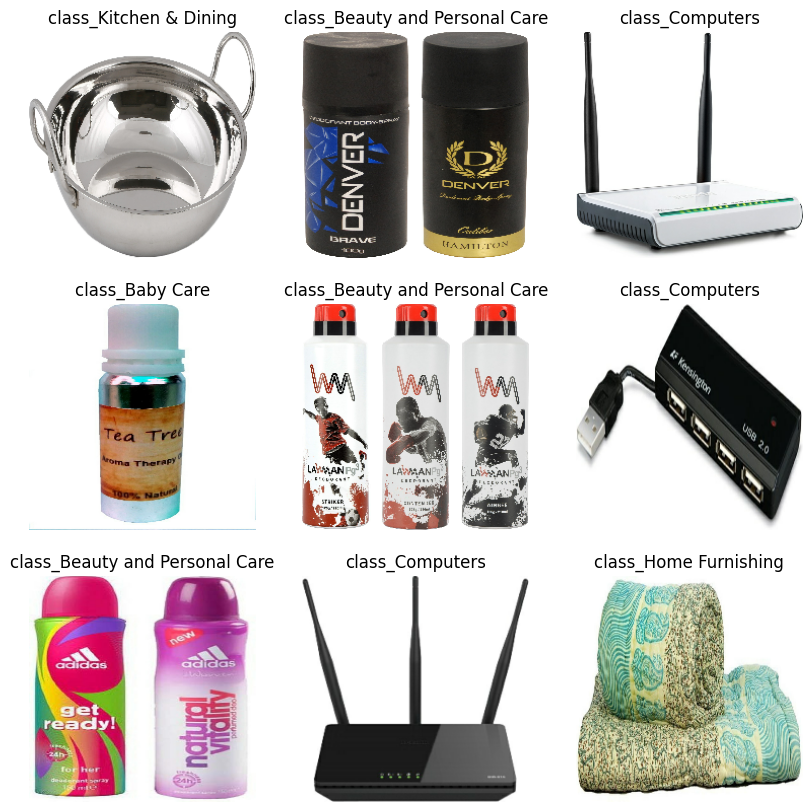

In [52]:
# Visualisation

plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Quelques exemples avec leur label pour vérifier si les images ont été placées dans le bon répertoire.

In [53]:
for image_batch, labels_batch in dataset_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


L' image_batch est un tenseur de la forme (32, 224, 224, 3) . Il s'agit d'un lot de 32 images de forme 224x224x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le label_batch est un tenseur de la forme (32,) , ce sont des labels correspondants aux 32 images.

In [54]:
# Création du modèle
model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [55]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
temps3 = time.time()

history3 = model3.fit(dataset_train, validation_data=dataset_val,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)

duration3=time.time()-temps3
print("temps de T-SNE : ", "%15.2f" % duration3, "secondes")

Epoch 1/20


D:\anaconda3\envs\tf-2-9-1\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - ETA: 0s - loss: 6.3175 - accuracy: 0.4222
Epoch 1: val_loss improved from inf to 1.81325, saving model to .\model3_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 6.3175 - accuracy: 0.4222 - val_loss: 1.8133 - val_accuracy: 0.7190
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 2.6320 - accuracy: 0.6921
Epoch 2: val_loss improved from 1.81325 to 1.44459, saving model to .\model3_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 2.6320 - accuracy: 0.6921 - val_loss: 1.4446 - val_accuracy: 0.7810
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.7683
Epoch 3: val_loss improved from 1.44459 to 1.08988, saving model to .\model3_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 1.3848 - accuracy: 0.7683 - val_loss: 1.0899 - val_accuracy: 0.7905
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss:

In [57]:
loss3_train, accuracy3_train = model3.evaluate(dataset_train, verbose=True)
loss3_val, accuracy3_val = model3.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 0.8507 - accuracy: 0.8333


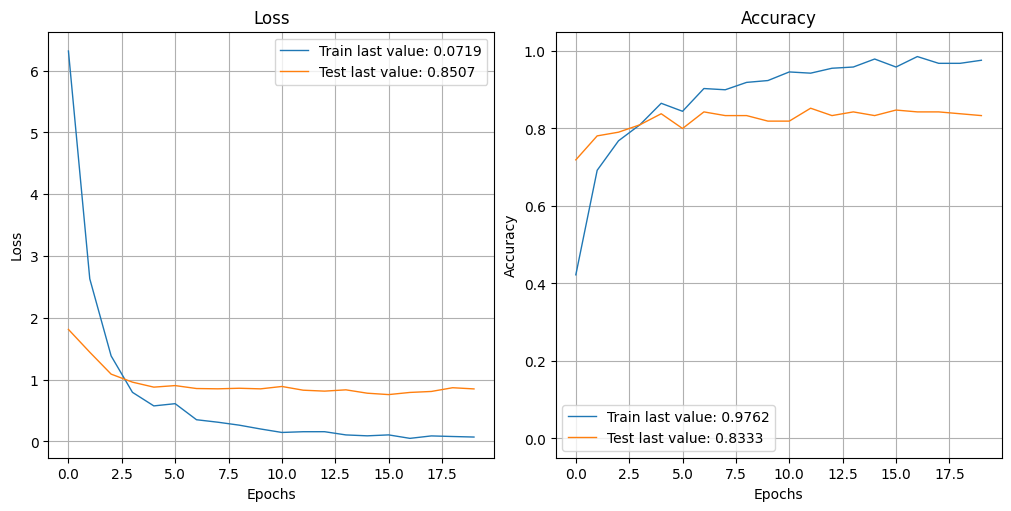

In [58]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

Les scores sont très bons mais le modèle est en overfitting.

In [59]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model3.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 1s 837ms/step
[5, 6, 4, 5, 6, 2, 3, 5, 0, 5, 0, 1, 0, 5, 2, 3, 4, 3, 3, 2, 5, 1, 4, 1, 5, 4, 5, 5, 4, 0, 6, 2, 3, 1, 3, 1, 0, 0, 4, 3, 5, 0, 5, 6, 3, 2, 2, 2, 3, 2, 3, 0, 2, 4, 6, 6, 3, 0, 0, 6, 5, 4, 5, 2, 1, 0, 2, 5, 6, 0, 4, 0, 2, 2, 5, 0, 1, 1, 1, 5, 5, 3, 2, 3, 5, 2, 1, 1, 5, 4, 5, 5, 3, 5, 6, 2, 1, 1, 4, 5, 2, 1, 0, 4, 6, 4, 0, 4, 3, 2, 4, 4, 2, 5, 1, 3, 0, 1, 4, 4, 6, 3, 1, 1, 0, 2, 3, 2, 0, 1, 5, 6, 0, 6, 0, 4, 1, 3, 4, 5, 3, 3, 2, 5, 4, 3, 5, 3, 6, 3, 5, 5, 1, 0, 0, 6, 3, 4, 6, 5, 6, 5, 6, 1, 0, 3, 4, 3, 0, 4, 6, 6, 5, 2, 4, 4, 2, 1, 6, 2, 6, 5, 0, 6, 1, 0, 1, 4, 5, 2, 3, 3, 4, 3, 6, 6, 6, 4, 6, 0, 6, 4, 6, 3, 3, 1, 5, 3, 5, 3]

[5, 6, 3, 5, 6, 2, 3, 5, 0, 5, 0, 4, 0, 2, 2, 3, 0, 3, 3, 2, 5, 1, 4, 1, 5, 4, 5, 5, 4, 0, 6, 2, 3, 1, 3, 1, 3, 0, 4, 3, 5, 0, 5, 6, 2, 2, 4, 2, 3, 2, 3, 0, 2, 4, 6, 6, 3, 0, 4, 6, 5, 0, 5, 2, 1, 0, 2, 5, 6, 0, 4, 0, 1, 2, 2, 0, 1, 1, 3, 5, 5, 3, 2, 3, 5, 2, 1, 1, 5, 4, 5, 5, 3, 5, 6, 4, 1, 1, 0, 5, 2, 1, 0, 4, 6,

In [60]:
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)
print(conf_mat)
print(metrics.classification_report(true_labels, predicted_labels))

[[23  0  1  3  1  0  0]
 [ 0 21  1  3  1  0  0]
 [ 0  2 22  0  2  0  0]
 [ 1  2  2 27  0  2  0]
 [ 7  0  0  1 22  0  0]
 [ 0  1  4  0  0 32  0]
 [ 0  0  0  1  0  0 28]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.81      0.81      0.81        26
           2       0.73      0.85      0.79        26
           3       0.77      0.79      0.78        34
           4       0.85      0.73      0.79        30
           5       0.94      0.86      0.90        37
           6       1.00      0.97      0.98        29

    accuracy                           0.83       210
   macro avg       0.83      0.83      0.83       210
weighted avg       0.84      0.83      0.83       210



<Axes: >

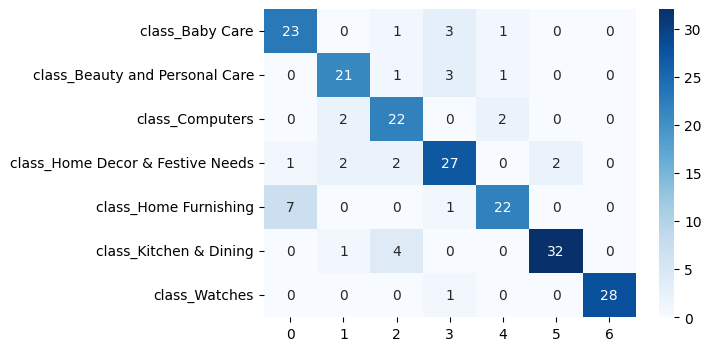

In [61]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. La classe Kitchen et dining est trop souvent prédite.

### Prédictions sur le data test

In [62]:
predictions3 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model3.predict(images)
    predictions3 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions3)

1/1 [==============================] - 1s 755ms/step
[1, 5, 2, 1, 0, 1, 5, 5, 6, 1, 6, 3, 4, 0, 0, 4, 0, 2, 4, 4, 0, 6, 4, 2, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 0, 2, 4, 5, 3, 0, 3, 6, 3, 5, 1, 3, 1, 4, 5, 0, 6, 1, 3, 0, 0, 0, 5, 4, 4, 4, 4, 2, 6, 4, 2, 0, 0, 2, 1, 6, 0, 3, 1, 6, 5, 6, 5, 2, 3, 0, 0, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 4, 6, 4, 4, 1, 5, 2, 2, 1, 1, 1, 5, 3, 1, 2, 3, 6, 0, 5, 3, 1, 0, 6, 3, 6, 3, 5, 3, 5, 3, 6, 4, 5, 1, 1, 2, 3, 1, 4, 5, 0, 5, 3, 0, 4, 6, 1, 4, 3, 2, 1, 5, 3, 5, 5, 2, 4, 4, 4, 2, 2, 5, 1, 6, 6, 2, 6, 6, 1, 0, 3, 5, 5, 5, 3, 2, 6, 2, 0, 2, 6, 5, 1, 5, 1, 6, 1, 2, 2, 0, 4, 3, 2, 3, 0, 2, 1, 3, 0, 4, 3, 4, 4, 5, 0, 3, 2, 5, 6, 6, 2, 2, 6]

[2, 5, 3, 4, 0, 0, 5, 0, 6, 1, 6, 3, 4, 0, 0, 4, 0, 2, 4, 4, 4, 6, 4, 6, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 4, 2, 4, 5, 3, 0, 3, 6, 3, 5, 1, 3, 0, 4, 5, 0, 6, 1, 3, 0, 0, 0, 1, 3, 4, 4, 4, 2, 6, 4, 3, 0, 0, 1, 1, 6, 0, 3, 2, 6, 5, 6, 5, 2, 3, 3, 3, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 0, 6, 4, 4, 1, 5, 2, 2,

In [63]:
score3_r2 = model3.evaluate(dataset_test)[1]
print("r2 : ",score3_r2)

7/7 [==============================] - 9s 1s/step - loss: 1.4994 - accuracy: 0.8190
r2 :  0.8190476298332214


In [64]:
score3_ari = metrics.adjusted_rand_score(labels_test, predictions3)
print("ARI : ", score3_ari)

ARI :  0.6314915894360487


### batch_size à 64

In [65]:
batch_size = 64

# Création du modèle
model3b = create_model_fct()

# Création du callback
model3b_save_path = "./model3b_best_weights.h5"
checkpoint = ModelCheckpoint(model3b_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [66]:
model3b.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
temps3b = time.time()

history3b = model3b.fit(dataset_train, validation_data=dataset_val,
                    batch_size=batch_size, epochs=30, callbacks=callbacks_list, verbose=1)

duration3b = time.time()-temps3b
print("temps de T-SNE : ", "%15.2f" % duration3b, "secondes")

Epoch 1/30


D:\anaconda3\envs\tf-2-9-1\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - ETA: 0s - loss: 7.4335 - accuracy: 0.4111
Epoch 1: val_loss improved from inf to 1.50837, saving model to .\model3b_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 7.4335 - accuracy: 0.4111 - val_loss: 1.5084 - val_accuracy: 0.7667
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 2.2844 - accuracy: 0.6905
Epoch 2: val_loss improved from 1.50837 to 1.23785, saving model to .\model3b_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 2.2844 - accuracy: 0.6905 - val_loss: 1.2378 - val_accuracy: 0.8048
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.4247 - accuracy: 0.7540
Epoch 3: val_loss improved from 1.23785 to 1.03691, saving model to .\model3b_best_weights.h5
20/20 [==============================] - 36s 2s/step - loss: 1.4247 - accuracy: 0.7540 - val_loss: 1.0369 - val_accuracy: 0.7857
Epoch 4/30
20/20 [==============================] - ETA: 0s - lo

In [68]:
loss3b_train, accuracy3b_train = model3b.evaluate(dataset_train, verbose=True)
loss3b_val, accuracy3b_val = model3b.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 9s 1s/step - loss: 0.7819 - accuracy: 0.8190


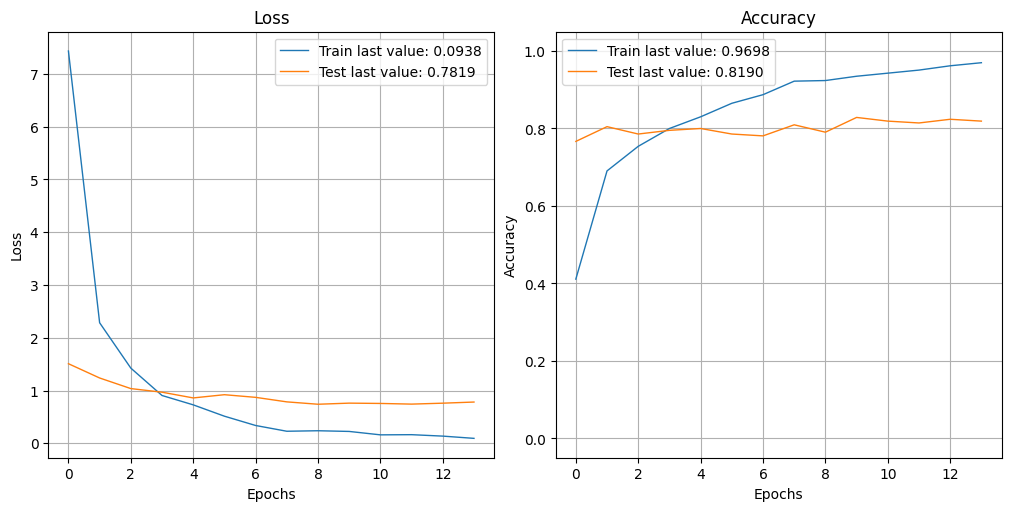

In [69]:
show_history(history3b)
plot_history(history3b, path="standard.png")
plt.close()

In [70]:
predictions3b = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model3b.predict(images)
    predictions3b += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions3b)

1/1 [==============================] - 1s 834ms/step
[4, 4, 0, 4, 0, 3, 4, 1, 5, 0, 2, 2, 6, 5, 3, 0, 4, 3, 0, 2, 6, 0, 1, 5, 2, 1, 3, 0, 1, 4, 4, 5, 6, 5, 1, 1, 0, 1, 2, 2, 6, 6, 1, 2, 6, 2, 3, 2, 4, 4, 5, 3, 6, 1, 1, 4, 6, 0, 3, 1, 1, 3, 0, 5, 6, 4, 5, 3, 4, 6, 6, 6, 3, 5, 2, 1, 5, 5, 5, 1, 2, 4, 6, 1, 4, 6, 2, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 5, 0, 4, 5, 2, 5, 3, 0, 6, 6, 3, 2, 3, 2, 6, 3, 1, 0, 5, 2, 3, 1, 6, 4, 3, 4, 2, 6, 5, 5, 3, 4, 1, 4, 0, 4, 6, 2, 1, 3, 1, 4, 2, 0, 5, 5, 0, 4, 2, 4, 5, 2, 0, 2, 4, 6, 5, 3, 1, 3, 0, 0, 1, 5, 0, 5, 2, 3, 3, 6, 3, 1, 1, 0, 2, 0, 2, 5, 1, 2, 5, 3, 1, 5, 2, 3, 0, 4, 6, 6, 0, 5, 2, 1, 0, 6, 3, 5, 6, 4, 6, 1, 6, 3, 1, 5, 4]

[4, 4, 0, 4, 0, 3, 4, 1, 5, 0, 2, 1, 6, 5, 3, 0, 4, 5, 5, 2, 6, 0, 1, 5, 2, 1, 3, 4, 1, 4, 0, 5, 6, 5, 1, 1, 4, 1, 2, 3, 6, 6, 1, 2, 6, 1, 0, 2, 1, 4, 5, 0, 6, 2, 3, 0, 6, 0, 3, 1, 2, 1, 0, 1, 5, 4, 5, 3, 4, 6, 6, 6, 3, 5, 2, 2, 5, 5, 5, 1, 1, 4, 6, 1, 4, 6, 2, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 5, 0,

In [71]:
score3b_r2 = model3b.evaluate(dataset_test)[1]
print("r2 : ",score3b_r2)

7/7 [==============================] - 9s 1s/step - loss: 0.9155 - accuracy: 0.8048
r2 :  0.8047618865966797


In [72]:
score3b_ari = metrics.adjusted_rand_score(labels_test, predictions3b)
print("ARI : ", score3b_ari)

ARI :  0.6164774589119402


Les scores sont légèrement moins bons avec un batch_size à 64 qu'à 32.

## <a name="7"> 4) Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [73]:
batch_size = 32

In [74]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [75]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [76]:
# Création du modèle
model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
temps4 = time.time()

history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=35, callbacks=callbacks_list, verbose=1)

duration4=time.time()-temps4
print("temps de T-SNE : ", "%15.2f" % duration4, "secondes")

Epoch 1/35
20/20 [==============================] - ETA: 0s - loss: 1.9330 - accuracy: 0.2079
Epoch 1: val_loss improved from inf to 1.48658, saving model to .\model4_best_weights.h5
20/20 [==============================] - 67s 3s/step - loss: 1.9330 - accuracy: 0.2079 - val_loss: 1.4866 - val_accuracy: 0.5476
Epoch 2/35
20/20 [==============================] - ETA: 0s - loss: 1.4559 - accuracy: 0.5349
Epoch 2: val_loss improved from 1.48658 to 1.14919, saving model to .\model4_best_weights.h5
20/20 [==============================] - 58s 3s/step - loss: 1.4559 - accuracy: 0.5349 - val_loss: 1.1492 - val_accuracy: 0.6857
Epoch 3/35
20/20 [==============================] - ETA: 0s - loss: 1.2008 - accuracy: 0.6381
Epoch 3: val_loss improved from 1.14919 to 0.95663, saving model to .\model4_best_weights.h5
20/20 [==============================] - 56s 3s/step - loss: 1.2008 - accuracy: 0.6381 - val_loss: 0.9566 - val_accuracy: 0.7476
Epoch 4/35
20/20 [==============================] - ETA:

In [78]:
loss4_train, accuracy4_train = model4.evaluate(dataset_train, verbose=True)
loss4_val, accuracy4_val = model4.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 14s 2s/step - loss: 0.5654 - accuracy: 0.7952


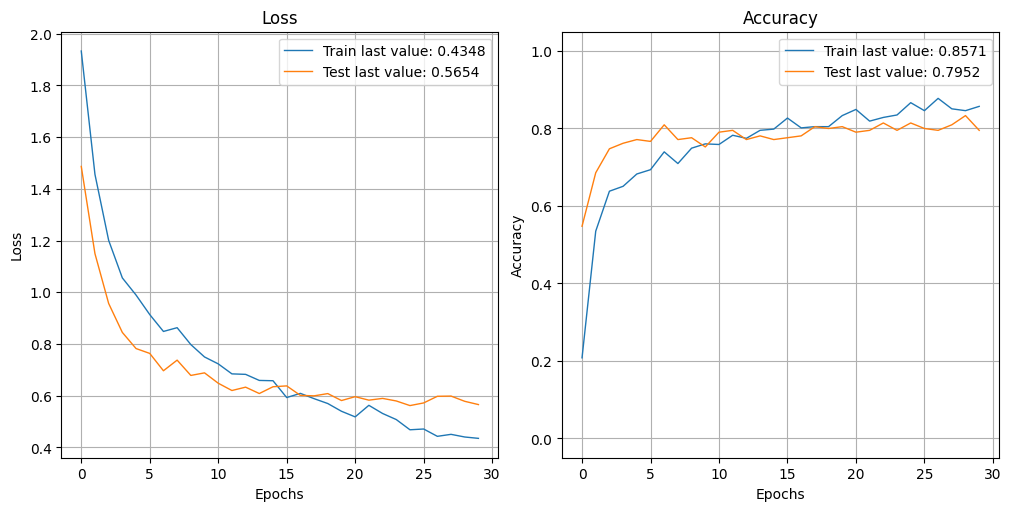

In [79]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

Les scores sont très bons et contrairement à l'approche sans data augmentation, le modèle arrive à généraliser.

In [80]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model4.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 1s 818ms/step
[6, 0, 1, 4, 6, 4, 6, 5, 6, 5, 0, 4, 4, 4, 6, 4, 3, 5, 0, 5, 6, 6, 6, 5, 2, 5, 1, 0, 2, 3, 3, 1, 3, 3, 6, 0, 2, 2, 5, 4, 3, 3, 6, 5, 2, 0, 4, 3, 6, 6, 4, 6, 2, 6, 5, 3, 5, 3, 2, 2, 5, 2, 1, 0, 3, 6, 2, 0, 4, 4, 3, 3, 2, 0, 5, 5, 3, 0, 1, 0, 4, 5, 6, 3, 2, 4, 2, 3, 4, 2, 6, 1, 5, 5, 5, 0, 1, 3, 4, 6, 4, 0, 2, 2, 5, 1, 3, 3, 4, 3, 6, 5, 1, 6, 0, 0, 4, 0, 3, 3, 1, 5, 5, 6, 0, 4, 5, 6, 2, 0, 4, 3, 4, 3, 6, 1, 4, 6, 0, 2, 2, 1, 5, 1, 1, 1, 3, 5, 5, 6, 0, 2, 3, 3, 5, 5, 5, 0, 4, 0, 1, 1, 4, 5, 2, 5, 0, 3, 0, 3, 1, 3, 4, 0, 5, 3, 5, 0, 3, 5, 4, 0, 3, 5, 2, 5, 2, 2, 6, 1, 1, 1, 6, 6, 5, 4, 6, 2, 2, 4, 0, 1, 1, 1, 5, 3, 1, 4, 4, 1]

[6, 0, 1, 4, 6, 4, 6, 5, 6, 5, 0, 4, 0, 4, 6, 4, 3, 5, 0, 5, 6, 6, 6, 5, 2, 5, 1, 4, 2, 0, 3, 1, 0, 2, 6, 4, 2, 1, 5, 4, 5, 3, 6, 5, 2, 0, 0, 3, 6, 6, 4, 6, 2, 2, 5, 3, 5, 3, 1, 2, 5, 2, 1, 0, 3, 6, 2, 5, 4, 4, 3, 3, 2, 4, 5, 5, 6, 0, 1, 0, 0, 5, 6, 3, 2, 4, 2, 3, 4, 2, 6, 1, 5, 5, 5, 0, 0, 5, 4, 6, 4, 0, 2, 2, 2,

In [81]:
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)
print(conf_mat)
print(metrics.classification_report(true_labels, predicted_labels))

[[20  0  0  2  5  1  0]
 [ 1 20  2  2  1  0  0]
 [ 0  3 22  0  0  1  0]
 [ 3  1  3 22  1  3  1]
 [ 5  1  1  0 22  1  0]
 [ 0  0  4  0  0 33  0]
 [ 0  0  1  0  0  0 28]]
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        28
           1       0.80      0.77      0.78        26
           2       0.67      0.85      0.75        26
           3       0.85      0.65      0.73        34
           4       0.76      0.73      0.75        30
           5       0.85      0.89      0.87        37
           6       0.97      0.97      0.97        29

    accuracy                           0.80       210
   macro avg       0.80      0.80      0.79       210
weighted avg       0.80      0.80      0.79       210



<Axes: >

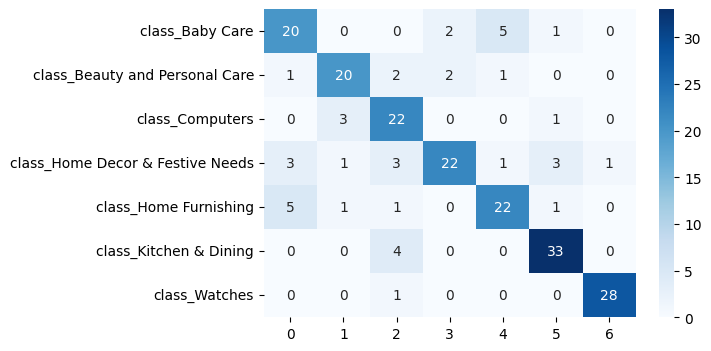

In [82]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. Toutefois, la classe Kitchen & dining est encore trop souvent prédite avec cette approche.

### Prédictions sur le data test

In [83]:
predictions4 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model4.predict(images)
    predictions4 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions4)

1/1 [==============================] - 1s 832ms/step
[4, 5, 6, 1, 6, 3, 3, 4, 5, 3, 4, 2, 3, 1, 5, 1, 2, 1, 6, 5, 2, 0, 0, 4, 4, 6, 0, 3, 4, 6, 2, 0, 5, 6, 1, 1, 0, 2, 3, 5, 2, 0, 5, 5, 0, 3, 5, 4, 5, 2, 6, 4, 2, 1, 5, 2, 0, 2, 3, 1, 4, 1, 1, 6, 5, 1, 3, 4, 6, 1, 4, 6, 2, 2, 6, 4, 5, 6, 0, 3, 4, 4, 5, 6, 1, 6, 3, 0, 4, 6, 6, 0, 2, 2, 3, 3, 0, 5, 0, 5, 0, 4, 1, 3, 5, 0, 3, 6, 0, 6, 1, 2, 2, 6, 5, 5, 6, 2, 5, 1, 1, 2, 0, 4, 4, 2, 4, 0, 5, 1, 3, 4, 1, 2, 5, 4, 0, 1, 1, 1, 3, 0, 4, 2, 2, 3, 3, 5, 3, 1, 4, 4, 2, 3, 2, 6, 3, 4, 0, 5, 0, 3, 5, 2, 0, 4, 6, 0, 3, 5, 5, 2, 1, 6, 2, 0, 0, 1, 2, 4, 2, 5, 0, 6, 0, 3, 3, 3, 3, 4, 6, 3, 1, 1, 0, 3, 6, 1, 6, 0, 1, 6, 4, 5, 5, 2, 6, 4, 1, 6]

[4, 5, 1, 1, 6, 3, 3, 4, 5, 2, 4, 2, 3, 1, 5, 1, 5, 1, 6, 5, 2, 0, 4, 4, 4, 6, 0, 5, 4, 6, 0, 4, 5, 6, 1, 4, 0, 2, 3, 5, 3, 0, 5, 5, 6, 3, 5, 4, 5, 2, 6, 3, 2, 1, 5, 2, 0, 2, 3, 1, 4, 0, 2, 6, 5, 1, 3, 4, 6, 1, 4, 6, 1, 2, 6, 4, 1, 6, 0, 3, 0, 4, 5, 6, 0, 6, 3, 3, 4, 6, 6, 0, 2, 2, 3, 3, 0, 1, 0, 0, 0, 0, 1, 3, 5,

In [84]:
score4_r2 = model4.evaluate(dataset_test)[1]
print("r2 : ",score4_r2)

7/7 [==============================] - 15s 2s/step - loss: 0.5924 - accuracy: 0.8238
r2 :  0.8238095045089722


In [85]:
score4_ari = metrics.adjusted_rand_score(labels_test, predictions4)
print("ARI : ", score4_ari)

ARI :  0.6337558943986346


### batch_size à 64

In [86]:
batch_size = 64

In [87]:
# Création du modèle
model4b = create_model_fct2()

# Création du callback
model4b_save_path = "./model4b_best_weights.h5"
checkpoint = ModelCheckpoint(model4b_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [88]:
temps4b = time.time()

history4b = model4b.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=30, callbacks=callbacks_list, verbose=1)

duration4b = time.time()-temps4b
print("temps de T-SNE : ", "%15.2f" % duration4b, "secondes")

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.9035 - accuracy: 0.2317
Epoch 1: val_loss improved from inf to 1.48528, saving model to .\model4b_best_weights.h5
20/20 [==============================] - 91s 4s/step - loss: 1.9035 - accuracy: 0.2317 - val_loss: 1.4853 - val_accuracy: 0.5143
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.4905
Epoch 2: val_loss improved from 1.48528 to 1.12606, saving model to .\model4b_best_weights.h5
20/20 [==============================] - 90s 4s/step - loss: 1.4744 - accuracy: 0.4905 - val_loss: 1.1261 - val_accuracy: 0.7619
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.5952
Epoch 3: val_loss improved from 1.12606 to 0.96370, saving model to .\model4b_best_weights.h5
20/20 [==============================] - 91s 5s/step - loss: 1.2251 - accuracy: 0.5952 - val_loss: 0.9637 - val_accuracy: 0.7524
Epoch 4/30
20/20 [==============================] - E

Epoch 20/30
20/20 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8302
Epoch 20: val_loss improved from 0.58106 to 0.57543, saving model to .\model4b_best_weights.h5
20/20 [==============================] - 91s 5s/step - loss: 0.5591 - accuracy: 0.8302 - val_loss: 0.5754 - val_accuracy: 0.8095
Epoch 21/30
20/20 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.8190
Epoch 21: val_loss did not improve from 0.57543
20/20 [==============================] - 91s 5s/step - loss: 0.5389 - accuracy: 0.8190 - val_loss: 0.5813 - val_accuracy: 0.8000
Epoch 22/30
20/20 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.8444
Epoch 22: val_loss did not improve from 0.57543
20/20 [==============================] - 92s 5s/step - loss: 0.5014 - accuracy: 0.8444 - val_loss: 0.5865 - val_accuracy: 0.8238
Epoch 23/30
20/20 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8317
Epoch 23: val_loss did not improve from 0.

In [89]:
loss4b_train, accuracy4b_train = model4b.evaluate(dataset_train, verbose=True)
loss4b_val, accuracy4b_val = model4b.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 20s 3s/step - loss: 0.5649 - accuracy: 0.8238


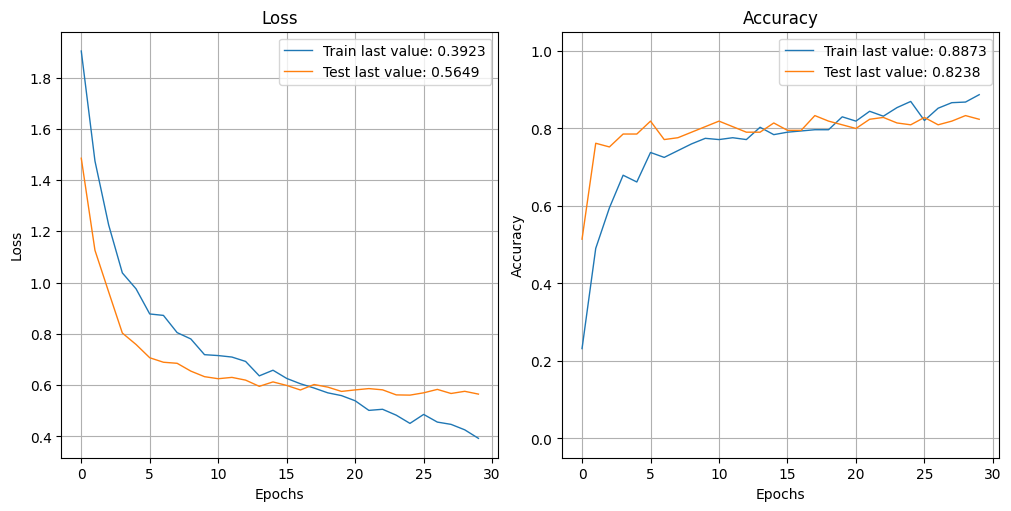

In [90]:
show_history(history4b)
plot_history(history4b, path="standard.png")
plt.close()

In [91]:
predictions4b = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model4b.predict(images)
    predictions4b += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions4b)

1/1 [==============================] - 1s 1s/step
[5, 1, 4, 2, 0, 3, 2, 2, 1, 2, 3, 5, 3, 0, 1, 1, 5, 3, 2, 4, 6, 3, 3, 1, 4, 4, 5, 5, 2, 6, 0, 6, 6, 2, 4, 3, 2, 4, 3, 6, 0, 0, 6, 1, 6, 6, 6, 2, 3, 2, 4, 0, 0, 1, 4, 6, 4, 6, 6, 5, 1, 4, 2, 3, 6, 4, 4, 1, 6, 6, 4, 4, 5, 5, 1, 1, 1, 1, 3, 3, 2, 2, 5, 6, 0, 4, 1, 5, 1, 3, 0, 2, 0, 0, 1, 4, 5, 5, 1, 3, 5, 0, 6, 5, 0, 4, 6, 2, 3, 4, 6, 4, 5, 2, 3, 5, 5, 3, 0, 4, 0, 0, 0, 3, 2, 6, 1, 1, 1, 3, 1, 2, 0, 6, 2, 4, 3, 2, 1, 5, 4, 1, 4, 0, 1, 0, 4, 5, 0, 4, 2, 3, 5, 5, 2, 2, 0, 6, 6, 5, 2, 0, 1, 4, 3, 6, 0, 2, 3, 4, 5, 0, 4, 5, 0, 1, 6, 0, 2, 3, 3, 2, 1, 2, 3, 4, 1, 1, 5, 6, 5, 0, 6, 6, 5, 3, 6, 2, 6, 0, 2, 5, 1, 3, 3, 5, 4, 0, 5, 3]

[5, 0, 4, 2, 0, 3, 2, 2, 1, 4, 3, 5, 2, 0, 1, 1, 5, 3, 2, 5, 6, 3, 3, 2, 4, 4, 5, 5, 2, 6, 0, 6, 6, 2, 2, 3, 2, 4, 3, 6, 0, 4, 6, 1, 6, 1, 6, 2, 3, 2, 4, 0, 4, 1, 4, 6, 4, 6, 6, 5, 2, 4, 2, 3, 6, 4, 4, 1, 6, 6, 4, 4, 5, 5, 4, 1, 6, 1, 3, 3, 2, 1, 5, 5, 0, 4, 1, 5, 1, 3, 0, 2, 4, 4, 1, 4, 1, 5, 1, 3, 5, 4, 6, 5, 0, 4,

In [92]:
score4b_r2 = model4b.evaluate(dataset_test)[1]
print("r2 : ",score4b_r2)

7/7 [==============================] - 17s 2s/step - loss: 0.6133 - accuracy: 0.8286
r2 :  0.8285714387893677


In [93]:
score4b_ari = metrics.adjusted_rand_score(labels_test, predictions4b)
print("ARI : ", score4b_ari)

ARI :  0.6447375681986157


Les scores sont légèrement meilleurs avec un batch_size à 64 qu'à 32 mais le temps d'apprentissage est plus long, on passe de 1984 secondes à 2664.

## <a name ='8'> Résultats

In [94]:
resultats = pd.DataFrame(index = ['modele_de_reference(b_s_64)', 'modele_de_reference(b_s_32)', 'ImageDataGenerator(b_s_32)',
                                  'ImageDataGenerator(b_s_64)', 'Approche_nouvelle(b_s_32)', 'Approche_nouvelle(b_s_64)',
                                  'Appr_nouv_avec_data_augmentation(b_s_32)', 'Appr_nouv_avec_data_augmentation(b_s_64)'],
                         columns = ['score_train_set', 'score_val_set', 'score_test_set', 'ARI', 'temps_entrainement(s)'])

In [95]:
resultats['score_train_set'] = [accuracy1_train, accuracy1b_train, accuracy2_train, accuracy2b_train, accuracy3_train, 
                                accuracy3b_train, accuracy4_train, accuracy4b_train]
resultats['score_val_set'] = [accuracy1_val, accuracy1b_val, accuracy2_val, accuracy2b_val, accuracy3_val, 
                              accuracy3b_val, accuracy4_val, accuracy4b_val]
resultats['score_test_set'] = [test_acc1, test_acc1b, score2_r2, score2b_r2, score3_r2, score3b_r2, score4_r2, score4b_r2]
resultats['ARI'] = [score1_ari, score1b_ari, score2_ari, score2b_ari, score3_ari, score3b_ari, score4_ari, score4b_ari]
resultats['temps_entrainement(s)'] = [duration1, duration1b, duration2, duration2b, duration3, duration3b, duration4, duration4b]
resultats

,score_train_set,score_val_set,score_test_set,ARI,temps_entrainement(s)
modele_de_reference(b_s_64),1.000000,0.828571,0.823810,0.642486,557.914469
modele_de_reference(b_s_32),1.000000,0.828571,0.823810,0.642486,383.034521
ImageDataGenerator(b_s_32),0.980952,0.838095,0.866667,0.720516,403.485244
ImageDataGenerator(b_s_64),0.977778,0.857143,0.828571,0.648953,403.611370
Approche_nouvelle(b_s_32),1.000000,0.833333,0.819048,0.631492,740.928191
Approche_nouvelle(b_s_64),1.000000,0.819048,0.804762,0.616477,506.479123
Appr_nouv_avec_data_augmentation(b_s_32),0.911111,0.795238,0.823810,0.633756,1984.815358
Appr_nouv_avec_data_augmentation(b_s_64),0.917460,0.823810,0.828571,0.644738,2664.646164


Les approches sans data augmentation ont un score de 100% sur le train_set. Elles sont en overfitting.

De plus, les approches avec data augmentation ont un meilleur score sur le test_set et sur l'ARI. En revanche, elles prennent plus de temps d'entraînement.

Les meilleurs résultats nous sont donnés par l'ImageDataGenerator avec un batch_size à 32. On obtient un score proche de 0.87 sur le test_set et un ARI de 0.72 pour un temps de 403s.